# **Explaning transformer models with SHAP**

## **Installing the modules**

In [1]:
!pip install --upgrade numpy shap transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.5 MB/s 
     |████████████████████████████████| 4.7 MB 38.7 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 101 kB 11.8 MB/s 
     |████████████████████████████████| 6.6 MB 30.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## **Loading the modules**

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(123)

import shap
print(f"Shap version used: {shap.__version__}")
import transformers
print(f"Hugging Face transformer version used: {transformers.__version__}")
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline
from typing import Union, List

Shap version used: 0.41.0
Hugging Face transformer version used: 4.21.0


## **SHAP and Hugging Face Transformers**

![SHAP and HF](https://raw.githubusercontent.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/main/Chapter07/images/Shap_HF.jpg)

In this tutorial we will apply SHAP for explaining Hugging Face transformer models trained on text data. Hugging Face Transformers (https://github.com/huggingface/transformers) are state of the art pre-trained transformer models trained on huge amount of data. This framework provides you the option of utilizing pre-trained models on various applications using just few lines of code. The pre-trained models can be easily downloaded and fine-tuned on any custom dataset and can be integrated very easily with other applications.

Now, let's try the hugging face transformer models for text sentiment analysis.

## **Explaining transformer based Sentiment Analysis models**

In [3]:
# Loading the transformers pipeline model for Sentiment analysis
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
# Loading the text data
text_data = "Hugging face transformers are absolutely brilliant!"

In [5]:
model(text_data)[0]

[{'label': 'NEGATIVE', 'score': 0.00013269631017465144},
 {'label': 'POSITIVE', 'score': 0.99986732006073}]

So, we can see that the model predicted the outcome to be positive with a very high confidence score, which is correct! Now, let's see if this can be explained using SHAP.

In [6]:
# Defining SHAP explainer object
explainer = shap.Explainer(model) 
shap_values = explainer([text_data])

In [7]:
shap.plots.text(shap_values[0,:,'POSITIVE'])

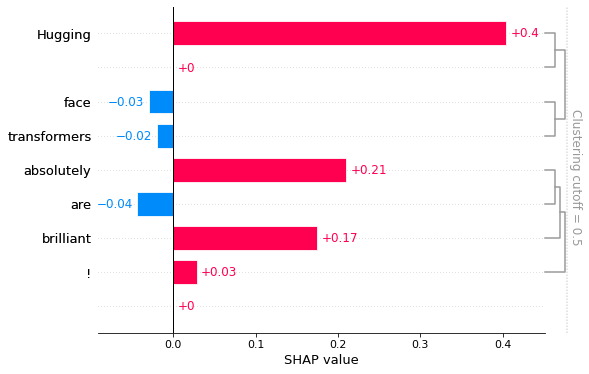

In [8]:
shap.plots.bar(shap_values[0,:,'POSITIVE'])

## **Explaining Zero-Shot Learning using SHAP**

In [10]:
# Loading the hugging face model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-3")
tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-3")

In [11]:
# Create a custom pipeline that only requires the text parameter 
# for the __call__ method and provides a method to set the labels
class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    def __call__(self, *args):
        out = super().__call__(args[0], self.set_labels)[0]

        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]

    def set_labels(self, labels: Union[str,List[str]]):
        self.set_labels = labels

In [12]:
def score_and_visualize(text, shap_values):
    prediction = pipe(text)
    print(f"Model predictions are: {prediction}")
    shap.plots.text(shap_values)

In [13]:
text = ["I love playing cricket!"]
labels = ["insect","sports", "animal"]

In [14]:
# Assign the labels for the classification model
model.config.label2id.update({v:k for k,v in enumerate(labels)})
model.config.id2label.update({k:v for k,v in enumerate(labels)})

In [15]:
pipe = ZeroShotModelPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
pipe.set_labels(labels)

In [16]:
# SHAP Explainer
explainer = shap.Explainer(pipe)
shap_values = explainer(text)

  0%|          | 0/42 [00:00<?, ?it/s]

Partition explainer: 2it [01:05, 65.18s/it]               


In [17]:
score_and_visualize(text, shap_values)

Model predictions are: [[{'label': 'sports', 'score': 0.8340923190116882}, {'label': 'insect', 'score': 0.1633770763874054}, {'label': 'animal', 'score': 0.0025305552408099174}]]


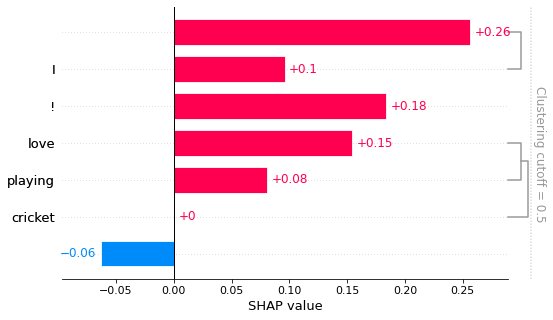

In [18]:
# Let's visualize the feature importance towards the outcome - sports
shap.plots.bar(shap_values[0,:,'sports'])

Hugging Face transformer framework, allows us to apply Zero-Shot learning in just few lines of code using pre-trained models without re-training or fine tuning on any labeled sample. Now, we have applied this model on a slightly difficult example. The example used is "I love playing cricket!". *Cricket* can be a sport or even it can an insect. So, ideally, the word cricket individually can contribute towards both the categories. But the term '*playing cricket*' definitely indicates the category sports. 

Although the model correctly predicted the category as sports, but when we used SHAP, we found out that the word *Cricket* has a negative contribution towards the model prediction. These are situations where model explainability is extremely crucial. Ideally speaking, the most important word that should contribute towards the correct prediction of the class sports, should have been *Cricket* and not *love*. This tells us that model is not robust enough and does have scope of improvement especially for the classes used for prediction.

## **References**

1. Transformer Model - https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)
2. SHAP GitHub Project - https://github.com/slundberg/shap
3. SHAP Documentations - https://shap.readthedocs.io/en/latest/index.html
4. Hugging Face Transformer - https://github.com/huggingface/transformers
5. Hugging Face Zero-Shot Learning - https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681
6. Zero-Shot Learning - https://towardsdatascience.com/zero-and-few-shot-learning-c08e145dc4ed
7. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073